# Set up

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Main approaches for Dimensionality Reductions

## Projection

Here we generate a small 3D dataset. It's an oval shape, rotated in 3D space, with points distributed unevenly, and quite a bit of noise.

In [2]:
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5
X += 0.28 * np.random.randn(m, 3)  # add more noises
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(
    X
)  # Rotate the dataset
X += [0.2, 0, 0.2]  # Shift a bit

Plot the 3D dataset, with the projection plane.

In [3]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # dataset reduced to 2D
X3D_inv = pca.inverse_transform(X2D)  # 3D position of the projected sample
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

In [4]:
axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(
    np.linspace(axes[0], axes[1], 10), np.linspace(axes[2], axes[3], 10)
)
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # projection plane coefficients
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # plane
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # samples above plane
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # samples below plane

In [5]:
from mpl_toolkits.mplot3d.axes3d import Axes3D


def set_xyz_axes(ax: Axes3D, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

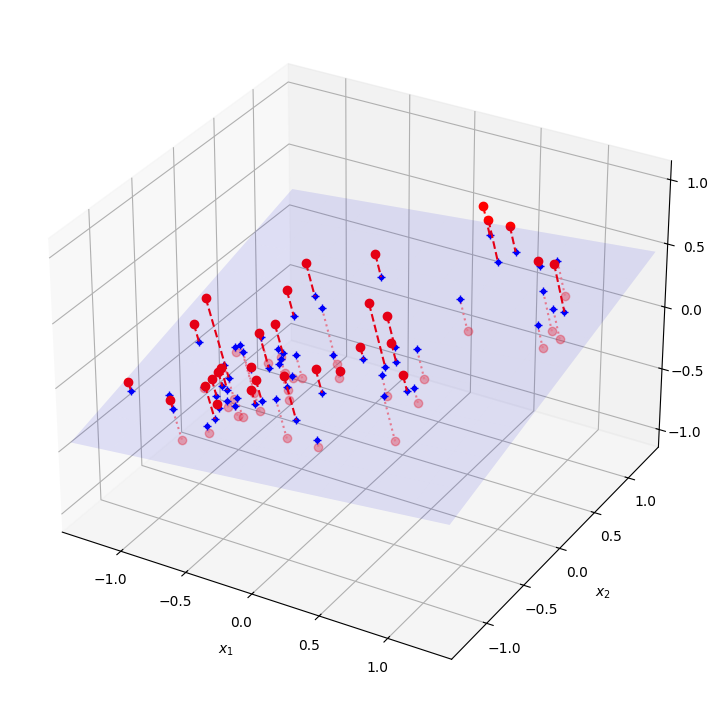

In [6]:
fig = plt.figure(figsize=(10, 9))
ax = fig.add_subplot(111, projection="3d")

# Draw instances and projection lines below plane first
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot(
            [X[i][0], X3D_inv[i][0]],
            [X[i][1], X3D_inv[i][1]],
            [X[i][2], X3D_inv[i][2]],
            ":",
            color="#F88",
        )

# Now we plot the projection plane and the projection samples
ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # projection plane
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")

# Lastly, draw instances and projection lines above plane
for i in range(m):
    if X[i, 2] > X3D_inv[i, 2]:
        ax.plot(
            [X[i][0], X3D_inv[i][0]],
            [X[i][1], X3D_inv[i][1]],
            [X[i][2], X3D_inv[i][2]],
            "r--",
        )
ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

plt.show()

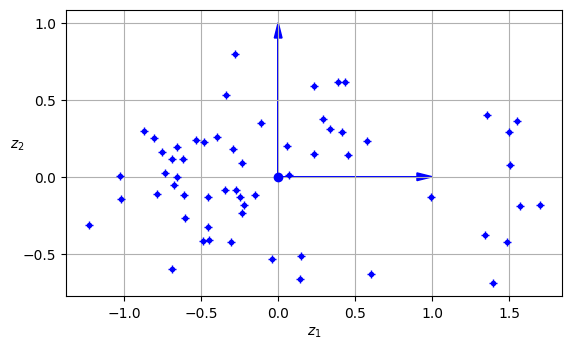

In [7]:
fig = plt.figure()
ax = fig.add_subplot(111, aspect="equal")
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")

ax.plot(0, 0, "bo")
ax.arrow(
    0,
    0,
    0,
    1,
    head_width=0.05,
    length_includes_head=True,
    head_length=0.1,
    fc="b",
    ec="b",
)
ax.arrow(
    0,
    0,
    1,
    0,
    head_width=0.05,
    length_includes_head=True,
    head_length=0.1,
    fc="b",
    ec="b",
)

ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0)
ax.set_yticks([-0.5, 0, 0.5, 1])
plt.grid()
plt.show()

## Manifold Learning

In [8]:
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

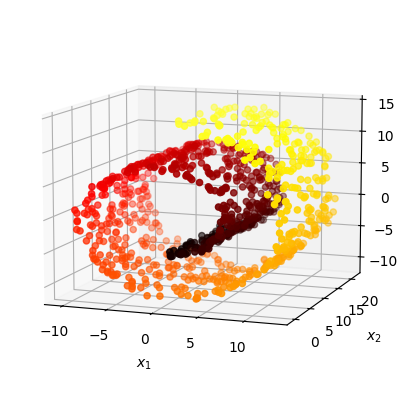

In [9]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection="3d")

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)

plt.show()

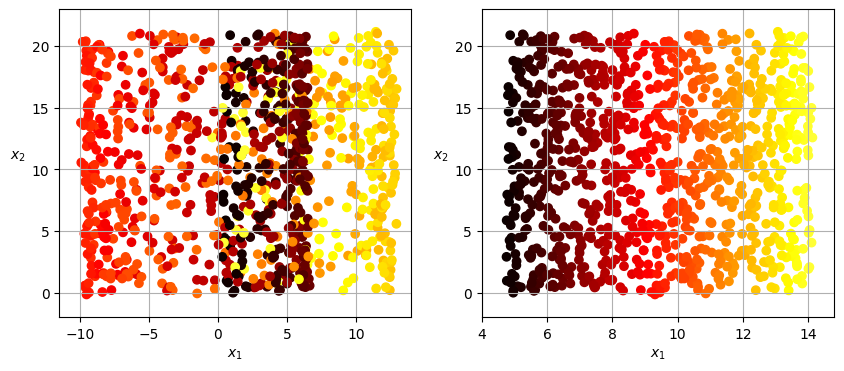

In [10]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.show()

In [11]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

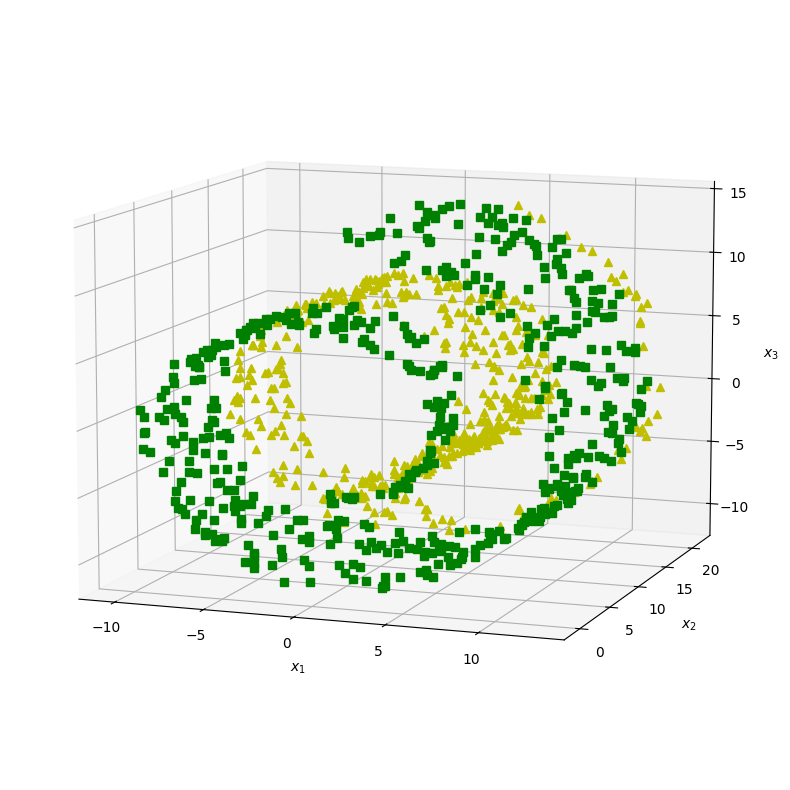

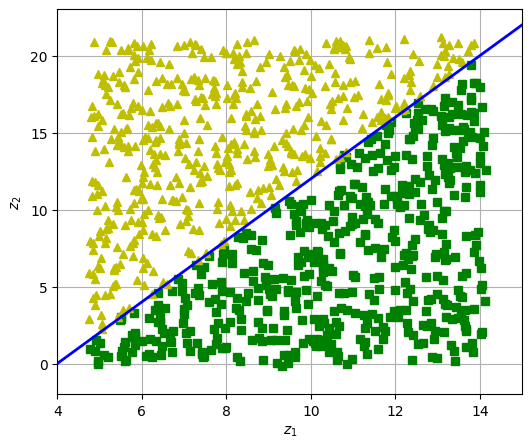

In [28]:
positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection="3d")
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.grid()

plt.show()

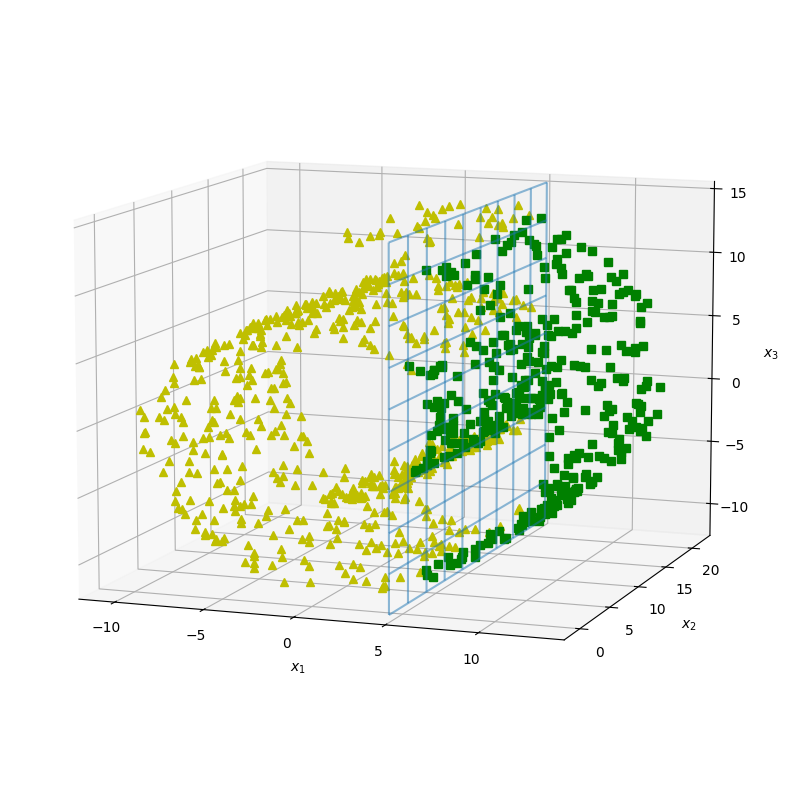

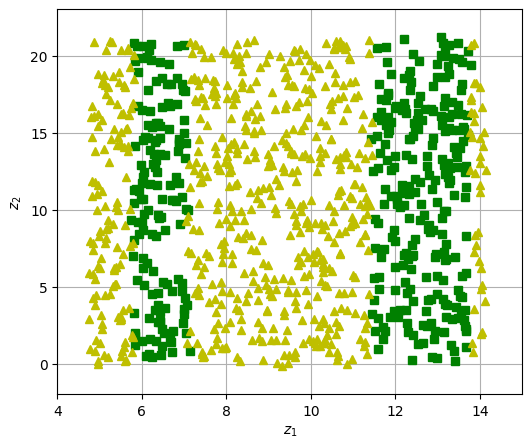

In [29]:
positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(10, 10))
ax = plt.subplot(111, projection="3d")
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(111)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$")
ax.grid()

plt.show()